In [1]:
import geopandas as gpd
from engine import *
from tqdm import tqdm

In [2]:
### Cargamos datos
agebs = gpd.read_file("agebs_ZM_del_Valle_de_México.geojson")
## Calculamos el centroide de cada ageb
agebs["centroide"] = agebs["geometry"].centroid

<ipython-input-2-ce129b986191>:4: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  agebs["centroide"] = agebs["geometry"].centroid


<AxesSubplot:>

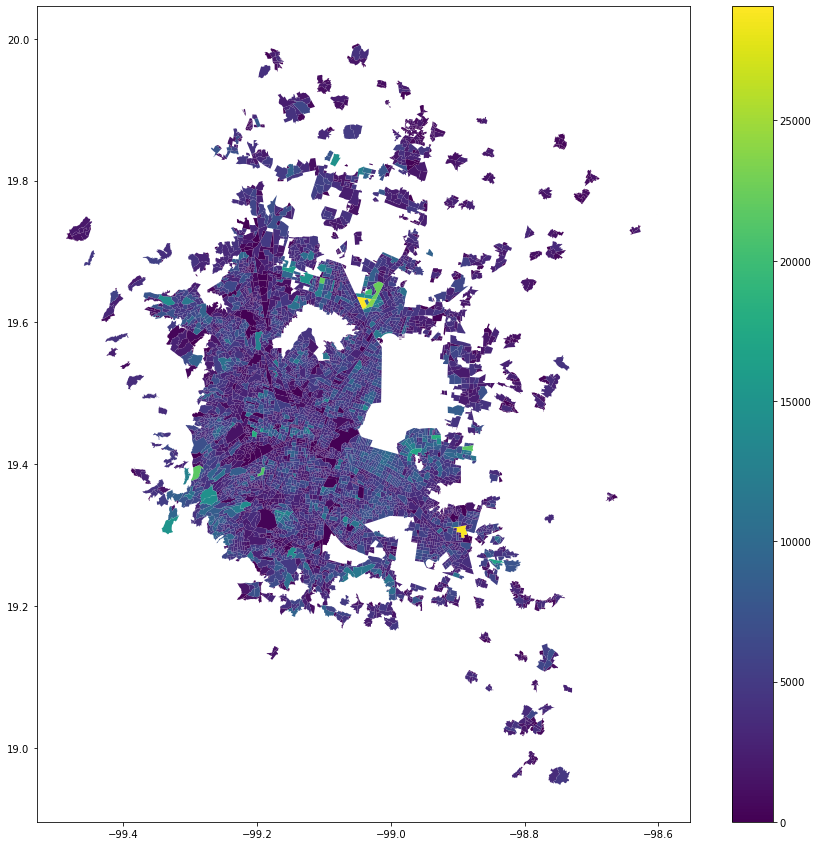

In [3]:
### Vemos el mapa
agebs.plot(column='POBTOT',figsize=(15, 15), legend=True)

In [4]:
## Obtenemos la matriz de adjacencia de los vecinos de los agebs
print("%-------------------------------------------------------------%")
print("Obtenemos la matriz de adjacencia de los vecinos de los agebs")
print("%--------------------------------------------------------------%")

adyacencia_dic = layer2net(agebs)

  0%|          | 0/5876 [00:00<?, ?it/s]

%-------------------------------------------------------------%
Obtenemos la matriz de adjacencia de los vecinos de los agebs
%--------------------------------------------------------------%


100%|██████████| 5876/5876 [37:09<00:00,  2.64it/s]  


In [5]:
### Definimos las clases y sus atributos
class Ageb:
    def __init__(self,cvegeo,poblacion,geometria,centroide):
        self.cvegeo = cvegeo
        self.poblacion = {0 : poblacion}
        self.vecinos = []
        self.geometria  = geometria
        self.centroide = centroide
        self.proba_ocupacion_inicial = {"zocalo": 0,"condesa" : 0,"reforma" : 0,"delValle": 0,"viveros" : 0,
            "vallejo" : 0,
            "cu": 0,
            "polanco" : 0,
            "santafe" : 0}
        self.proba_ocupacion_min = 0
        self.distancia_vecino = {}
        self.ruta_vecino = {}
        self.distancias_cbd = {"zocalo": 0,"condesa" : 0,"reforma" : 0,"delValle": 0,"viveros" : 0,
            "vallejo" : 0,
            "cu": 0,
            "polanco" : 0,
            "santafe" : 0}
        self.distancias_min_cbd = 0

class Network:
    def __init__(self):
        self.agebs ={}


In [6]:
# Instancia de la clase Network()
agebs_net = Network()

# Agregamos las instancias de cada ageb en el diccionacio de agebs_net
print("%-------------------------------------------------------------%")
print("Agregamos las instancias de cada ageb en el diccionacio de agebs_net")
print("%--------------------------------------------------------------%")
for ageb in tqdm(list(adyacencia_dic.keys())):
    poblacion = agebs[agebs["CVEGEO"]==ageb]["POBTOT"].item()
    geometria = agebs[agebs["CVEGEO"]==ageb]["geometry"].item()
    centroide = agebs[agebs["CVEGEO"]==ageb]["centroide"].item()
    agebs_net.agebs[ageb]=Ageb(ageb,poblacion,geometria,centroide)

# Agregamos los vecinos de cada ageb
print("%-------------------------------------------------------------%")
print("Agregamos los vecinos de cada ageb")
print("%--------------------------------------------------------------%")
for ageb in tqdm(list(adyacencia_dic.keys())):
    lista_vecinos = list(np.where((adyacencia_dic[ageb]==1))[0])
    ref_vecinos = []

    if len(lista_vecinos)==0:
        pass
    else:
        for vecino in np.take(list(agebs_net.agebs.keys()),lista_vecinos):
            ref_vecinos.append(agebs_net.agebs[vecino])
        agebs_net.agebs[ageb].vecinos=ref_vecinos


  0%|          | 2/5876 [00:00<05:04, 19.27it/s]

%-------------------------------------------------------------%
Agregamos las instancias de cada ageb en el diccionacio de agebs_net
%--------------------------------------------------------------%


  2%|▏         | 136/5876 [00:00<00:04, 1351.36it/s]

%-------------------------------------------------------------%
Agregamos los vecinos de cada ageb
%--------------------------------------------------------------%


100%|██████████| 5876/5876 [00:04<00:00, 1365.90it/s]


In [7]:
### Diccionario de principales destinos de trabajo
destinos = {"zocalo": (19.432229587797913, -99.13342540255914),
            "condesa" :(19.41500702816897, -99.17754326239348),
            "reforma" : (19.42631517782024, -99.19379876201027),
            "delValle": (19.373937627246054, -99.17861804875692),
            "viveros": (19.35420491791415, -99.17548474041028),
            "vallejo" : (19.49489893376003, -99.1647650982302),
            "cu": (19.322740688438223, -99.1866604705067),
            "polanco" : (19.433666445182244, -99.19094770204629),
            "santafe" : (19.361383705434182, -99.27367230390125)}


In [13]:
### Definimos función para calcular distancia geodésica
import geopy.distance

def get_distancias(origen,destino):
    origen = tuple(reversed(origen.centroide.coords[0]))
    dist = geopy.distance.geodesic(origen,destino)
    
    return dist.meters


In [14]:
### Obtenemos las distancias con respecto a los centros laborales 
for key_ageb,ageb in tqdm(agebs_net.agebs.items()):
    for k,v in destinos.items():
        ageb.distancias_cbd[k]=get_distancias(ageb,v)
        
### Verificamos con un ageb
agebs_net.agebs['0900500010366'].distancias_cbd

100%|██████████| 5876/5876 [00:07<00:00, 763.97it/s]


{'zocalo': 11292.60113952977,
 'condesa': 12451.974367392599,
 'reforma': 11414.871227022111,
 'delValle': 16998.95351389038,
 'viveros': 19173.05851958197,
 'vallejo': 3679.510835689592,
 'cu': 22703.716285870603,
 'polanco': 10558.689793701995,
 'santafe': 21240.70748760737}

In [15]:
for key_ageb,ageb in tqdm(agebs_net.agebs.items()):
    ageb.distancias_min_cbd= min(ageb.distancias_cbd.values())

## Probamos
agebs_net.agebs['0900500010366'].distancias_min_cbd,agebs_net.agebs['0900500010366'].distancias_cbd

100%|██████████| 5876/5876 [00:00<00:00, 520732.12it/s]


(3679.510835689592,
 {'zocalo': 11292.60113952977,
  'condesa': 12451.974367392599,
  'reforma': 11414.871227022111,
  'delValle': 16998.95351389038,
  'viveros': 19173.05851958197,
  'vallejo': 3679.510835689592,
  'cu': 22703.716285870603,
  'polanco': 10558.689793701995,
  'santafe': 21240.70748760737})

100%|██████████| 5876/5876 [00:00<00:00, 1464392.77it/s]


<AxesSubplot:>

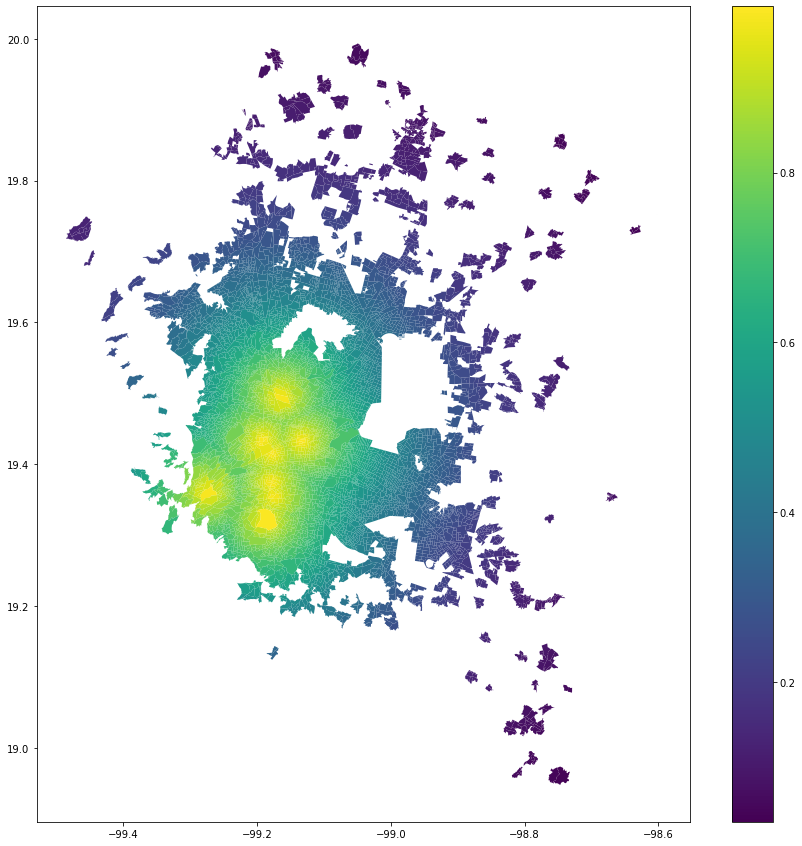

In [16]:
## Exponencial 1
### Calculamos la probabilidad inicial de cada ageb
b = 5

for key_ageb,ageb in tqdm(agebs_net.agebs.items()):
    r = ageb.distancias_min_cbd/100000
    ageb.proba_ocupacion_min=np.exp(-b*r)
#### Guardamos la probabilidad inicial con respecto juriquilla
proba_lista = []

for key_ageb,ageb in tqdm(agebs_net.agebs.items()):
    proba_lista.append(ageb.proba_ocupacion_min)
    
df = pd.DataFrame({"cvegeo":agebs['CVEGEO'],'proba_inicial': proba_lista,"geometry":agebs['geometry']})
gdf = gpd.GeoDataFrame(df, geometry='geometry')

gdf.plot(column='proba_inicial',figsize=(15, 15), legend=True)